Daniel Lee

July 25, 2018

# Regression in Python

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression

Linear regression is used to model and predict continuous outcomes with normal random errors. There are nearly an infinite number of different types of regression models and each regression model is typically defined by the distribution of the prediction errors (called "residuals") of the type of data. Logistic regression is used to model binary outcomes whereas Poisson regression is used to predict counts. In this exercise, we'll see some examples of linear regression as well as Train-test splits.

The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

In [2]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.graphics import utils
from matplotlib.lines import Line2D

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")


***
# Part 1: Introduction to Linear Regression

### A Brief Mathematical Recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is **linearly** related to the dependent variable $Y$. The most basic linear regression model contains one independent variable $X$, we'll call this the simple model. 

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. In linear regression, $\epsilon$ is assumed to be normally distributed with a mean of 0. In other words, what this means is that on average, if we know $Y$, a roughly equal number of predictions $\hat{Y}$ will be above $Y$ and others will be below $Y$. That is, on average, the error is zero. The residuals, $\epsilon$ are also assumed to be "i.i.d.": independently and identically distributed. Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

* $\beta_0$ is the intercept of the linear model and represents the average of $Y$ when all independent variables $X$ are set to 0.

* $\beta_1$ is the slope of the line associated with the regression model and represents the average effect of a one-unit increase in $X$ on $Y$.

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
http://www.learner.org/courses/againstallodds/about/glossary.html

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once we estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, we can use these to predict new values of $Y$ given new data $X$.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

* Multiple linear regression is when you have more than one independent variable and the estimation involves matrices
    * $X_1$, $X_2$, $X_3$, $\ldots$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is the most common methods
    * We will discuss least squares

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 
    
### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the squared residuals: 

$$ \mathscr{L} = \sum_{i=1}^N \epsilon_i = \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2  = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

where $N$ is the number of observations and $\epsilon$ represents a residual or error, ACTUAL - PREDICTED.  

#### Estimating the intercept $\hat{\beta_0}$ for the simple linear model

We want to minimize the squared residuals and solve for $\hat{\beta_0}$ so we take the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta_0}$ 

Using this new information, we can compute the estimate for $\hat{\beta}_1$ by taking the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta}_1$.

***
# Part 2: Exploratory Data Analysis for Linear Relationships

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in suburbs of Boston.  This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 


## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [3]:
from sklearn.datasets import load_boston

boston = load_boston()

In [4]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [5]:
boston.data.shape

(506, 13)

In [6]:
# Print column names
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [7]:
# Print description of Boston housing data set
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Now let's explore the data set itself. 

In [8]:
bos = pd.DataFrame(boston.data)
bos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


There are no column names in the DataFrame. Let's add those. 

In [9]:
bos.columns = boston.feature_names
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

In [10]:
print(boston.target.shape)

(506,)


In [11]:
bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [12]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Scatterplots
***

Let's look at some scatter plots for three variables: 'CRIM' (per capita crime rate), 'RM' (number of rooms) and 'PTRATIO' (pupil-to-teacher ratio in schools).  

Text(0.5,1,'Relationship between CRIM and Price')

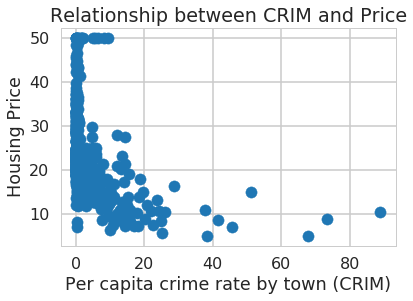

In [13]:
plt.scatter(bos.CRIM, bos.PRICE)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Housing Price")
plt.title("Relationship between CRIM and Price")

---

# Part 2 Checkup Exercise Set I

**1. What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?**

I see a negative relationship. That is, as `Per capita crime rate by town (CRIM)` increases, `Housing Price` decreases. The relationship is non-linear. What's strange/interesting about the data is that the `Housing Price` has a maximum value at $50,000. 16 houses have this price. 

In [14]:
bos.PRICE[bos.PRICE == max(bos.PRICE)].shape

(16,)

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


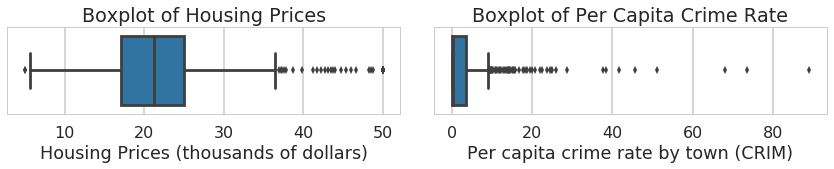

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 3))
_ = sns.boxplot(bos.PRICE, ax = ax1)
_ = ax1.set_xlabel('Housing Prices (thousands of dollars)')
_ = ax1.set_title('Boxplot of Housing Prices')
_ = sns.boxplot(bos.CRIM, ax = ax2)
_ = ax2.set_xlabel('Per capita crime rate by town (CRIM)')
_ = ax2.set_title('Boxplot of Per Capita Crime Rate')
fig.tight_layout(rect = [0, 0.03, 1, 0.85])
fig.show()

Based on the boxplots, I can see a handful of outliers for both `Housing Price` and `CRIM`.

**2. Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


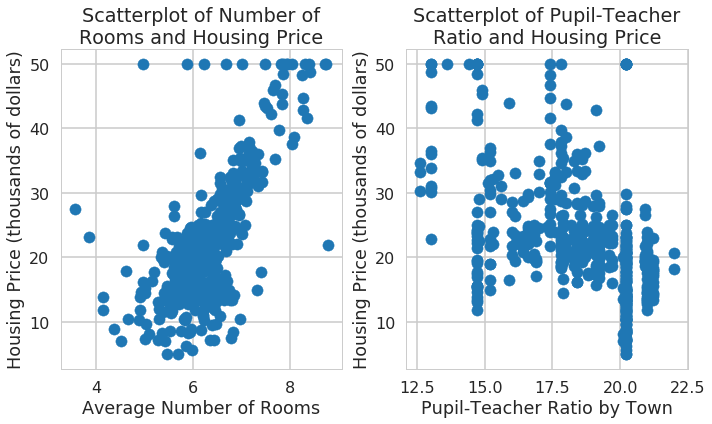

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
_ = ax1.scatter(bos.RM, bos.PRICE)
_ = ax1.set_xlabel('Average Number of Rooms')
_ = ax1.set_ylabel('Housing Price (thousands of dollars)')
_ = ax1.set_title('Scatterplot of Number of\nRooms and Housing Price')
_ = ax2.scatter(bos.PTRATIO, bos.PRICE)
_ = ax2.set_xlabel('Pupil-Teacher Ratio by Town')
_ = ax2.set_ylabel('Housing Price (thousands of dollars)')
_ = ax2.set_title('Scatterplot of Pupil-Teacher\nRatio and Housing Price')
fig.tight_layout()
fig.show()

**`Housing Price` vs `Average Number of Rooms`**: As average numer of rooms increase, housing price also increases. The relationship seems to be linear for the most part. However, there are some outliers at the extreme values where the relationship is no longer linear. There are a few houses that do not have many rooms but the price is pretty high. And then there are houses that have many rooms but the price is quite low. These points should be investigated further to see why this is the case.

**`Housing Price` vs `Pupil-Teacher Ratio by Town`**: As the pupil-teacher ratio by town increases, housing price decreases. However, the relationship does not seem to be very predictive. That is, given a pupil-teacher ratio, there's quite a bit of variation in terms of housing prices. The plot also indicates that many towns have the same number of pupil-teacher ratio by town.

**3. What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


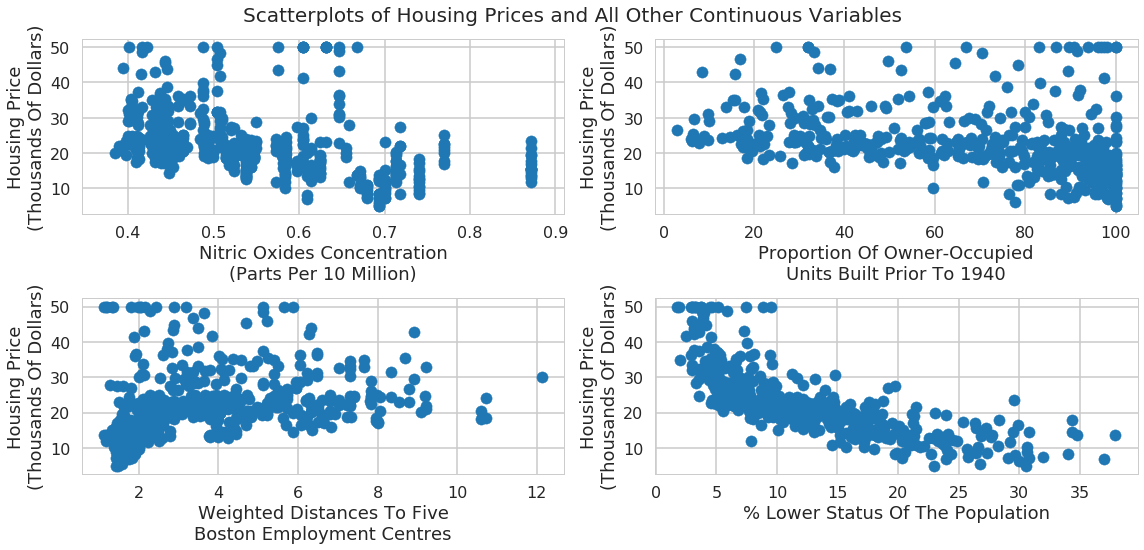

In [17]:
bos_interesting_columns = bos[['NOX', 'AGE', 'DIS', 'LSTAT', 'PRICE']]
bos_interesting_columns.columns = ['nitric oxides concentration\n(parts per 10 million)',
                               'proportion of owner-occupied\nunits built prior to 1940',
                               'weighted distances to five\nBoston employment centres',
                               '% lower status of the population',
                               'Housing Price\n(Thousands of dollars)']

bos_interesting_columns.columns = [column.title() for column in bos_interesting_columns]

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
for i, ax in enumerate(axes.flatten()):
    _ = ax.scatter(x = bos_interesting_columns.iloc[:, i], y = bos_interesting_columns.iloc[:, -1])
    _ = ax.set_ylabel(bos_interesting_columns.columns[-1], fontsize = 18)
    _ = ax.set_xlabel(bos_interesting_columns.columns[i], fontsize = 18)
fig.suptitle('Scatterplots of Housing Prices and All Other Continuous Variables', fontsize = 20)
fig.tight_layout(rect = [0, 0.03, 1, 0.95])
fig.show()

**`Nitric Oxides Concentration` vs `Housing Price`**: This is interesting because my initial thought is that pollution levels would affect housing prices. As the scatter plot shows, higher the pollution level, the lower the housing price. However, the relationship does not seem to be very strongly linear.

**`Proportion Of Owner-Occupied Units Built Prior To 1940` vs `Housing Price`**: This is interesting because I would imagine that older houses would be cheaper. The scatter plot shows this. Generally, older houses are cheaper. However, there's still a good amount of houses that are quite old and the house prices are still quite high. This relationship is nonlinear.

**`Weighted Distances To Five Boston Employment Centres` vs `Housing Price`**: This is interesting because I would imagine that the closer the houses are to employment centers, the cheaper the housing prices. However, this is not necessarily the case. There are quite a bit of houses that are cheaper because they are closer to employment centers. However, after a certain distance, the housing prices don't vary as much.

**`% Lower Status of the Population` vs `Housing Price`**: This is interesting because I would imagine that the higher the percentage of lower status, the lower the housing price. And this is indeed the case. However, the relationship is not linear. It seems to be more exponential.

### Scatterplots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

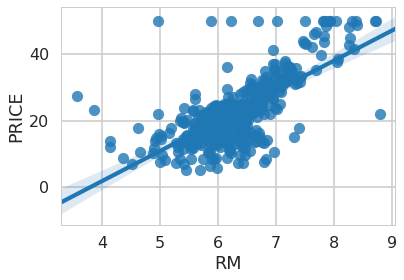

In [18]:
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True)
plt.show()

### Histograms
***


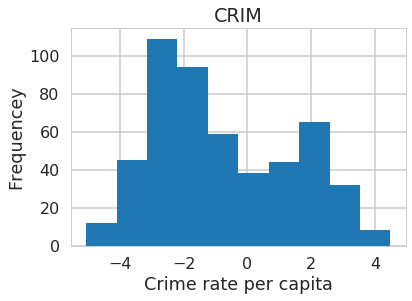

In [19]:
plt.hist(np.log(bos.CRIM))
plt.title("CRIM")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequencey")
plt.show()

***
# Part 2 Checkup Exercise Set II

**1. In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


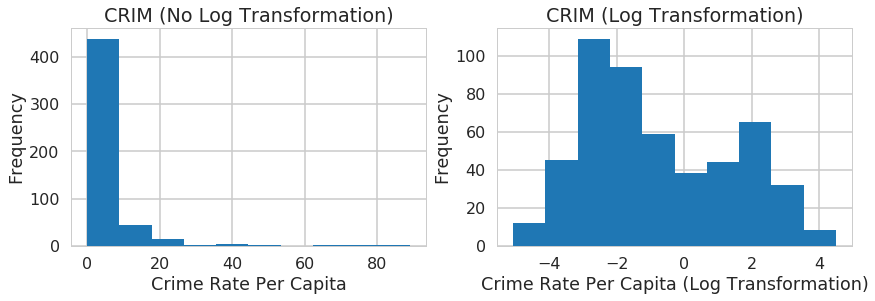

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4))

_ = ax1.hist(bos.CRIM)
_ = ax1.set_title('CRIM (No Log Transformation)')
_ = ax1.set_xlabel('Crime Rate Per Capita')
_ = ax1.set_ylabel('Frequency')
_ = ax2.hist(np.log(bos.CRIM))
_ = ax2.set_title('CRIM (Log Transformation)')
_ = ax2.set_xlabel('Crime Rate Per Capita (Log Transformation)')
_ = ax2.set_ylabel('Frequency')
fig.show()

One common purpose of taking the log transformation is to make highly skewed distributions less skewed. It does this because the log transformation spreads out data points that are close to each other. At the same time, the log transformation also reduces the distance between the data points that are far apart from each other. That is why we see the range of the log transformation is a lot smaller than the range of the data that did not undergo log transformation. Further, we see that the log transformation distributed the data points evenly, whereas the raw data points have a high concentration of data points at every small values.

By taking the log, we see that the highly right-skewed distribution has become a more bimodal distribution.

Also, log transformation leads to seeing a stronger correlation between variables.

**2. Plot the histogram for *RM* and *PTRATIO* against each other, along with the two variables you picked in the previous section. We are looking for correlations in predictors here.**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py

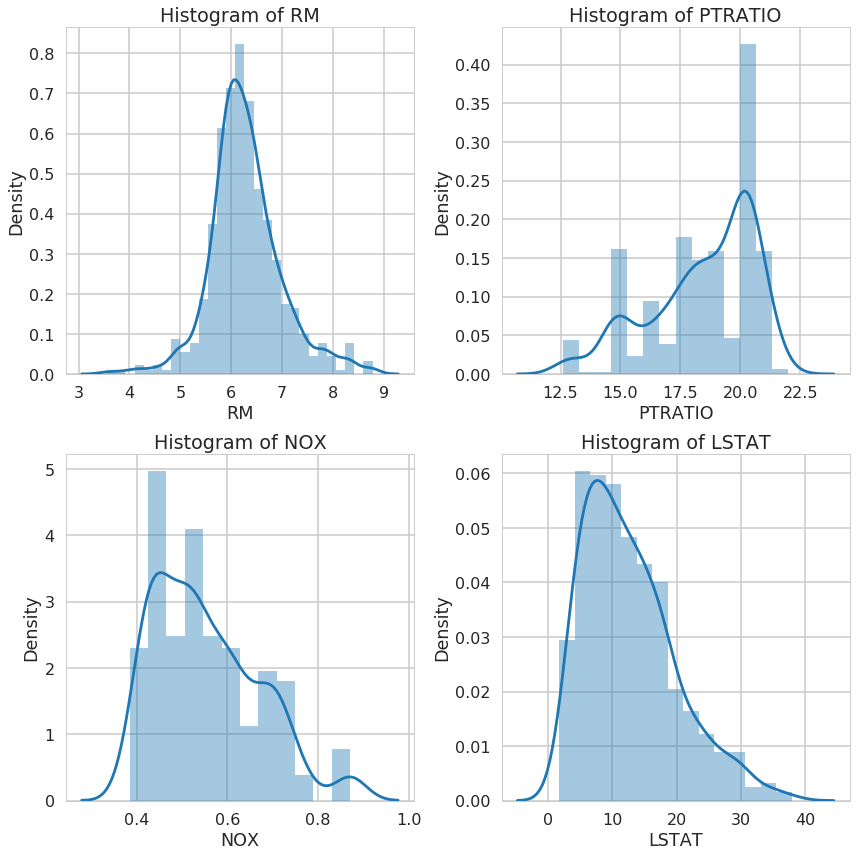

In [32]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))

# get index of RM, PTRATIO, NOX, LSAT:
wanted_cols = ['RM', 'PTRATIO', 'NOX', 'LSTAT']

for i, ax in enumerate(axes.flatten()):
    
    _ = sns.distplot(a = bos.loc[:, wanted_cols[i]], norm_hist = True, ax = ax)
    _ = ax.set_xlabel(wanted_cols[i])
    _ = ax.set_ylabel('Density')
    _ = ax.set_title('Histogram of {}'.format(wanted_cols[i]))

fig.tight_layout()
fig.show()

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


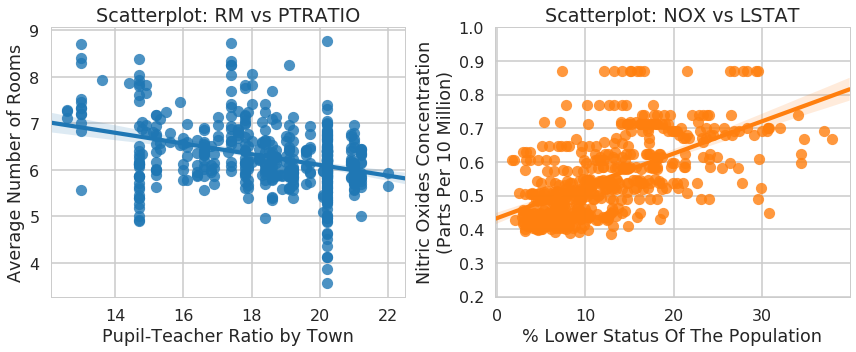

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
_ = sns.regplot(y = "RM", x = "PTRATIO", data = bos, ax = ax1)
_ = ax1.set_xlabel('Pupil-Teacher Ratio by Town')
_ = ax1.set_ylabel('Average Number of Rooms')
_ = ax1.set_title('Scatterplot: RM vs PTRATIO')
_ = sns.regplot(y = 'NOX', x = 'LSTAT', data = bos, ax = ax2)
_ = ax2.set_xlabel('% lower status of the population'.title())
_ = ax2.set_ylabel('nitric oxides concentration\n(parts per 10 million)'.title())
_ = ax2.set_title('Scatterplot: NOX vs LSTAT')
_ = ax2.set_ylim((0.2, 1))
fig.tight_layout()
fig.show()

From the scatterplots and the histograms above, I see that there's some level of correlation between `RM` and `PTRATIO` as well as between `NOX` and `LSTAT`. This indicates that there's some level of collinearity among the predictors.

## Part 3: Linear Regression with Boston Housing Data Example
***

Here, 

$Y$ = boston housing prices (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least-squares method to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [21]:
# Import regression modules
import statsmodels.api as sm

In [22]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
m = ols('PRICE ~ RM',bos).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Wed, 25 Jul 2018   Prob (F-statistic):           2.49e-74
Time:                        02:19:47   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. This means that the number of rooms, `RM`, is a statisticall significant predictor of `PRICE`. The regression coefficient for `RM` of 9.1021 means that *on average, each additional room is associated with an increase of $\$9,100$ in house price net of the other variables*. The confidence interval gives us a range of plausible values for this average change, about ($\$8,279, \$9,925$), definitely not chump change. 

In general, the $\hat{\beta_i}, i > 0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat{\beta_i}$ increase/decrease in $y$ net of all other variables."

On the other hand, the interpretation for the intercept, $\hat{\beta}_0$ is the average of $y$ given that all of the independent variables $x_i$ are 0.

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), but you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is doone like this:

`Outcome ~ X1 + X2 + X3`

In general, a formula for an OLS multiple linear regression is

`Y ~ X1 + X2 + ... + Xp`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex. You can force statsmodels to treat variables as categorical with the `C()` function, call numpy functions to transform data such as `np.log` for extremely-skewed data, or fit a model without an intercept by including `- 1` in the formula. For a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ceiling effect, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

# Part 3 Checkup Exercise Set I
***

**1. Create a scatterplot between the predicted prices, available in `m.fittedvalues` (where `m` is the fitted model) and the original prices. How does the plot look? Do you notice anything interesting or weird in the plot? Comment on what you see.**

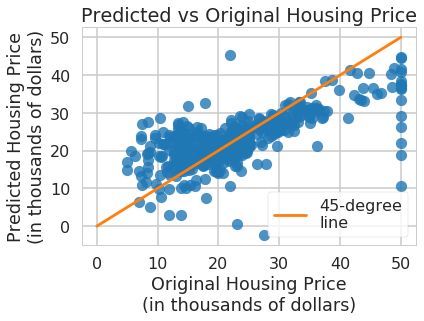

In [23]:
_ = sns.regplot(y = m.fittedvalues, x = bos.PRICE, fit_reg = False)
_ = plt.ylabel('Predicted Housing Price\n(in thousands of dollars)')
_ = plt.xlabel('Original Housing Price\n(in thousands of dollars)')
_ = plt.title('Predicted vs Original Housing Price')
_ = plt.plot([0, 50], [0, 50]) # 45 degree line
_ = plt.legend(['45-degree\nline'], frameon = True)
plt.show()

All the points below the 45-degree line are under-predictions and all the points above it are over-predictions. I see that for the most part, the points are close to the 45-degree line. However, there are a handful of points where the predictions are very different than the original price. One of the predictions have a negative value, which doesn't make sense. Also, all the houses that have price at $50,000 have lower predicted values.

### Fitting Linear Regression using `sklearn`


In [24]:
from sklearn.linear_model import LinearRegression
X = bos.drop('PRICE', axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here. Most machine learning models in scikit-learn follow this same API of fitting a model with `fit`, making predictions with `predict` and the appropriate scoring function `score` for each model.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

In [25]:
lm.fit(X = X, y = bos.PRICE)
y_pred = lm.predict(X = X)
lm.score(X = X, y = bos.PRICE) # R^2 value

0.7406077428649428

#### What output can you get?

In [26]:
# Look inside lm object
# lm.<tab>

In [27]:
print('Estimated coefficients: {}\nEstimated intercept: {}'.format(lm.coef_, lm.intercept_))

Estimated coefficients: [-1.07170557e-01  4.63952195e-02  2.08602395e-02  2.68856140e+00
 -1.77957587e+01  3.80475246e+00  7.51061703e-04 -1.47575880e+00
  3.05655038e-01 -1.23293463e-02 -9.53463555e-01  9.39251272e-03
 -5.25466633e-01]
Estimated intercept: 36.49110328036135


Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [28]:
# Use all 13 predictors to fit linear regression model
lm.fit(X = X, y = bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

***
# Part 3 Checkup Exercise Set II

**1. How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-is-regression-through-the-origin/).**

To remove the intercept using `statsmodels`, run the following code:

In [29]:
# fit the linear model using all the variables and remove intercept
all_columns = "+".join(bos.columns[:-1]) # string processing to create equation
my_formula = "PRICE~" + all_columns + '-1' # string processing to remove intercept
m_no_intercept = ols(formula=my_formula, data=bos).fit()
print(m_no_intercept.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     891.1
Date:                Wed, 25 Jul 2018   Prob (F-statistic):               0.00
Time:                        02:19:48   Log-Likelihood:                -1523.8
No. Observations:                 506   AIC:                             3074.
Df Residuals:                     493   BIC:                             3129.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.0916      0.034     -2.675      0.0

To remove the intercept using `sklearn`, run the following code.

In [30]:
# This creates a LinearRegression object without intercept
lm_no_intercept = LinearRegression(fit_intercept = False)
lm_no_intercept.fit(X = X, y = bos.PRICE)
print('Estimated coefficients: {}\nEstimated intercept: {}'.format(lm_no_intercept.coef_, lm_no_intercept.intercept_))

Estimated coefficients: [-9.16297843e-02  4.86751203e-02 -3.77930006e-03  2.85636751e+00
 -2.88077933e+00  5.92521432e+00 -7.22447929e-03 -9.67995240e-01
  1.70443393e-01 -9.38925373e-03 -3.92425680e-01  1.49832102e-02
 -4.16972624e-01]
Estimated intercept: 0.0


For this particular data, I would recommend to have an intercept because it seems to makes more sense that way. For example, if a house has zero rooms, it should still have a default house price. If the percent of lower status of the population is zero, the house should still have a default house price. If the house exists, there should be a default price for the house. One note is that it wouldn't make sense that the weighted distances to five Boston employment centers would be zero for a given house. So, it would be impossible for the weighted distances to five Boston employment centers would be zero.

**2. One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.**

I would think that normality of residuals is not enough to prove that residuals are i.i.d. but am not sure about this. 

Even if the residuals are not normally distributed, that does not necessarily mean that the residuals are i.i.d. This can just mean that the residuals are i.i.d. but the distribution is not normal.

If the residuals are normally distributed, this also does not mean that the residuals are i.i.d. This is because residuals can technically come from different distributions. And when these distributions combine, they can look like a normal distribution. 

One way to test for independence is to create scatter plots between the residuals and all other predictor variables. If there's a distinct pattern, then the independence assumption is violated. 

One way to test for identical distribution is to check for homoscedascity. If the variance seems to be changing with the fitted y-values or any of the predictor variables, then it suggests the residuals have different variances for different predictor/fitted-y values. This suggests that the residuals are not coming from identical distributions.

A sure way of testing for i.i.d. is to know the sampling procedure and the experiment design.

**3. True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.**

False. To use linear regression, $Y$ does not have to be normally distributed. The assumption is that the errors, $\epsilon$, are normally distributed. Then, by the linear model:

$$Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 

This means that $Y$ is also normally distributed, because linear combination of normal distributions are also normally distributed and the $X_i$s are assumed to be constants.

However, this assumption of $\epsilon$ being normally distributed is only important when doing hypothesis tests and constructing confidence intervals. To estimate $\beta_i$s does not require normality assumption. When we want to perform statistical inference by using the t distribution to determine statistical significance, then we assume normality. However, for this also, if we have sufficiently large sample size, by the CLT, the $\beta_i$s will be approximately normally distributed. Hence, we can still construct confidence intervals and calculate p-values by assuming normal distribution.

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [31]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_))

Estimated intercept coefficient: 36.49110328036135


In [32]:
print('Number of coefficients: {}'.format(len(lm.coef_)))

Number of coefficients: 13


In [33]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.107171
1,ZN,0.046395
2,INDUS,0.020860
3,CHAS,2.688561
4,NOX,-17.795759
5,RM,3.804752
6,AGE,0.000751
7,DIS,-1.475759
8,RAD,0.305655
9,TAX,-0.012329


### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [34]:
# first five predicted prices
y_pred_sklearn_lm = lm.predict(X)
y_pred_sklearn_lm[0:5]

array([30.00821269, 25.0298606 , 30.5702317 , 28.60814055, 27.94288232])

***
# Part 3 Checkup Exercise Set III

**1. Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


count    506.000000
mean      22.532806
std        7.914896
min       -4.283009
25%       17.447270
50%       22.120625
75%       27.412587
max       44.673399
dtype: float64

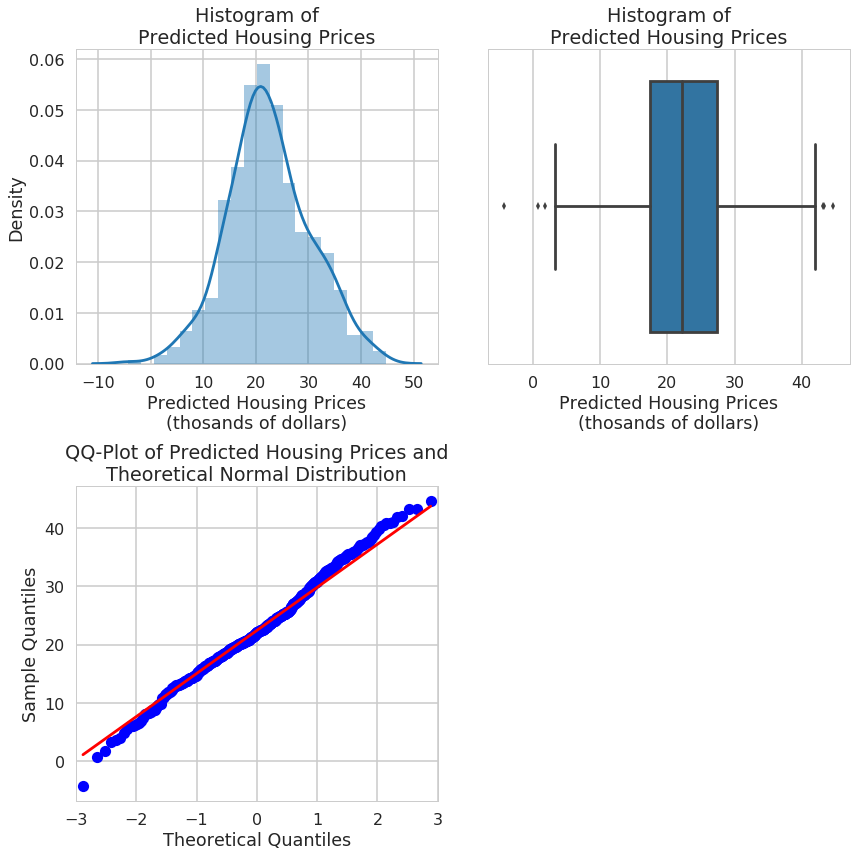

In [35]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))
flattened_axes = axes.flatten()
_ = sns.distplot(y_pred_sklearn_lm, ax = flattened_axes[0])
_ = flattened_axes[0].set_title('Histogram of\nPredicted Housing Prices')
_ = flattened_axes[0].set_xlabel('Predicted Housing Prices\n(thosands of dollars)')
_ = flattened_axes[0].set_ylabel('Density')
_ = sns.boxplot(y_pred_sklearn_lm, ax = flattened_axes[1])
_ = flattened_axes[1].set_title('Histogram of\nPredicted Housing Prices')
_ = flattened_axes[1].set_xlabel('Predicted Housing Prices\n(thosands of dollars)')
_ = sm.qqplot(y_pred_sklearn_lm, line = 'q', ax = flattened_axes[2])
_ = flattened_axes[2].set_title('QQ-Plot of Predicted Housing Prices and\nTheoretical Normal Distribution')
_ = flattened_axes[3].set_yticklabels('')
_ = flattened_axes[3].set_xticklabels('')
_ = flattened_axes[3].grid(False)
_ = flattened_axes[3].axis('off')
fig.tight_layout()
fig.show()
pd.Series(y_pred_sklearn_lm).describe()

There are 506 predicted values. The mean is \$22,533. The standard deviation is \$7,915. The median is \$22,121. The minimum value is -\$4,283. The maximum is \$44,673. The interquartile range is \$9,965. The shape is approximately a normal distribution.

There are outliers in the predicted values. The outliers are clear because these values don't make much sense. For instance, one value is predicted to be -\$4,283. Another house is predicted to be \$780. What we can do is to investigate further to see why this might be. Perhaps there was a typo in the predictor variables that are causing this to happen. Or, perhaps these values don't differ much from the true housing price values, in which case we should keep these outliers. 

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

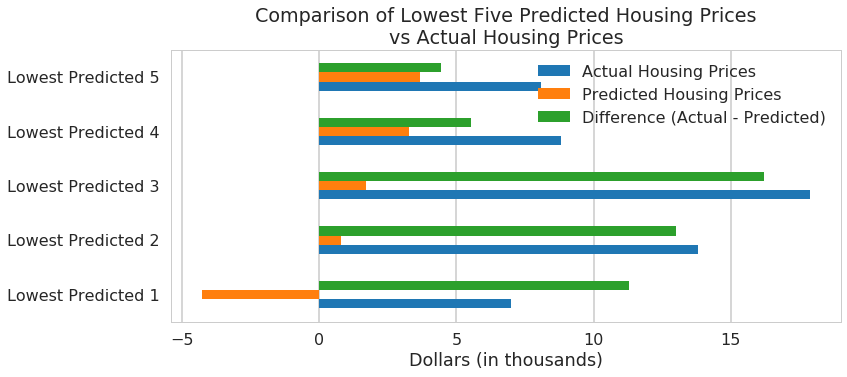

In [36]:
# take a look at the lowest five predicted values and compare them to the X and actual housing price
low_five = pd.Series(y_pred_sklearn_lm).sort_values().head().reset_index()
low_five_df = X.iloc[low_five['index'], :]
low_five_df['PRICE'] = bos.iloc[low_five['index'], bos.columns.get_loc('PRICE')]
low_five_df['predicted_price'] = list(low_five.iloc[:, 1])
low_five_df['difference'] = low_five_df['PRICE'] - low_five_df['predicted_price']
low_five_df.reset_index(inplace = True)

# side-by-side bar plot of predicted housing prices vs actual housing prices
fig, ax = plt.subplots(figsize = (12, 5))
_ = low_five_df.plot(x = 'index', y = low_five_df.columns[-3:], kind = 'barh', ax = ax)
ax.set_title('Comparison of Lowest Five Predicted Housing Prices\nvs Actual Housing Prices')
ax.set_xlabel('Dollars (in thousands)')
ax.set_ylabel('')
ax.set_yticklabels(['Lowest Predicted 1', 'Lowest Predicted 2', 'Lowest Predicted 3', 'Lowest Predicted 4', 'Lowest Predicted 5'])
ax.legend(['Actual Housing Prices', 'Predicted Housing Prices', 'Difference (Actual - Predicted)'])
ax.grid(b = False, axis = 'y') # turn off horizontal grid lines
fig.show()

From the barplot above, I can see that the predicted price does not differ much from the actual housing price. So, it seems as though the linear regression model is working as it's supposed to. The only thing we should adjust is that if the prices are predicted to be negative values, we should change them to a baseline price (e.g. the minimum housing price among the actual housing prices), because negative housing values don't make sense.

**2. Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before)**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


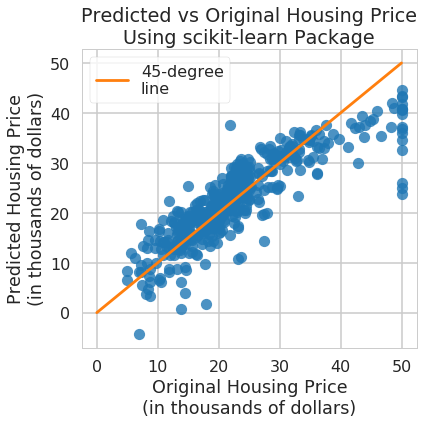

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

_ = sns.regplot(y = y_pred_sklearn_lm, x = bos.PRICE, fit_reg = False, ax = ax)
_ = ax.set_ylabel('Predicted Housing Price\n(in thousands of dollars)')
_ = ax.set_xlabel('Original Housing Price\n(in thousands of dollars)')
_ = ax.set_title('Predicted vs Original Housing Price\nUsing scikit-learn Package')
_ = ax.plot([0, 50], [0, 50]) # 45 degree line
_ = ax.legend(['45-degree\nline'], frameon = True)
fig.tight_layout()
fig.show()

All the points below the 45-degree line are under-predictions and all the points above it are over-predictions. I see that for the most part, the points are close to the 45-degree line. However, there are a handful of points where the predictions are very different than the original price. One of the predictions have a negative value, which doesn't make sense. Also, all the houses that have price at $50,000 have lower predicted values.

**3. We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?**

Based on exploring the two packages, `statsmodels` has an advantage in that it generates output in a convenient way. It generates a comprehensive report of the linear model using the `summary()` method. The `scikit-learn` linear regression model works too but it's a little more difficult to access all the necessary results. The advantage of `scikit-learn` is that it has the same model structure as all the other machine learning algorithms. Hence, it's easier to remember how to use.

### Evaluating the Model: Sum-of-Squares

The partitioning of the sum-of-squares shows the variance in the predictions explained by the model and the variance that is attributed to error.

$$TSS = ESS + RSS$$

#### Residual Sum-of-Squares (aka $RSS$)

The residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model. We will revisit this in a bit.

$$ RSS = \sum_{i=1}^N r_i^2 = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

In [38]:
print(np.sum((bos.PRICE - y_pred_sklearn_lm) ** 2))

11080.276284149873


#### Explained Sum-of-Squares (aka $ESS$)

The explained sum-of-squares measures the variance explained by the regression model.

$$ESS = \sum_{i=1}^N \left( \hat{y}_i - \bar{y} \right)^2 = \sum_{i=1}^N \left( \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) - \bar{y} \right)^2$$

In [39]:
print(np.sum(y_pred_sklearn_lm - np.mean(bos.PRICE)) ** 2)

9.11966625339713e-23


### Evaluating the Model: The Coefficient of Determination ($R^2$)

The coefficient of determination, $R^2$, tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model.

$$ R^2 = \frac{ESS}{TSS} $$

The $R^2$ value is one of the most common metrics that people use in describing the quality of a model, but it is important to note that *$R^2$ increases artificially as a side-effect of increasing the number of independent variables.* While $R^2$ is reported in almost all statistical packages, another metric called the *adjusted $R^2$* is also provided as it takes into account the number of variables in the model, and can sometimes even be used for non-linear regression models!

$$R_{adj}^2 = 1 - \left( 1 - R^2 \right) \frac{N - 1}{N - K - 1} = R^2 - \left( 1 - R^2 \right) \frac{K}{N - K - 1} = 1 - \frac{\frac{RSS}{DF_R}}{\frac{TSS}{DF_T}}$$

where $N$ is the number of observations, $K$ is the number of variables (not including the intercept), $DF_R = N - K - 1$ is the degrees of freedom associated with the residual error and $DF_T = N - 1$ is the degrees of the freedom of the total error.

### Evaluating the Model: Mean Squared Error and the $F$-Statistic
***
The mean squared errors are just the *averages* of the sum-of-squares errors over their respective degrees of freedom.

$$MSE = \frac{ESS}{K}$$
$$MSR = \frac{RSS}{N-K-1}$$

**Remember: ** Notation may vary across resources particularly the use of *R* and *E* in *RSS/ESS* and *MSR/MSE*. In some resources, E = explained and R = residual. In other resources, E = error and R = regression (explained). **This is a very important distinction that requires looking at the formula to determine which naming scheme is being used.**

Given the MSR and MSE, we can now determine whether or not the entire model we just fit is even statistically significant. We use an $F$-test for this. The null hypothesis is that all of the $\beta$ coefficients are zero, that is, none of them have any effect on $Y$. The alternative is that *at least one* $\beta$ coefficient is nonzero, but it doesn't tell us which one in a multiple regression:

$$H_0: \beta_i = 0, \mbox{for all $i$} \\
H_A: \beta_i \neq 0, \mbox{for some $i$}$$ 

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$
 
Once we compute the $F$-statistic, we can use the $F$-distribution with $N-K - 1$ and $K$ degrees of degrees of freedom to get a p-value.

**Warning!** The $F$-statistic mentioned in this section is NOT the same as the F1-measure or F1-value discused in Unit 7.